In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
import pandas as pd
import scipy as scp
import netCDF4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import pickle
import matplotlib.gridspec as gridspec

In [2]:
file_path1 = 'SSTs.nc'
file_path2 = 'TCs.nc'
  
#Opening dataset for tropics                                   
ds1 = xr.open_dataset(file_path1)
ds2 = xr.open_dataset(file_path2)

/Users/varinradia/anaconda3/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [3]:
ds_grouped = ds1.groupby('time.year').mean(dim='time')                                   #Obtained Yearly Meaned Data
tropical_data = ds_grouped.sel(latitude=slice(23.5, -23.5), longitude=slice(0, 360))    #Extracted Data For the Tropics

In [4]:
with open("storms_by_year.pk", "rb") as fin:  
 storms = pickle.load(fin)

In [5]:
# Initialize a dictionary to store storm information with latitudes and longitudes
storm_info = {}

# Iterate over the years in the storms dictionary
for year, storm_ids_year in storms.items():
    # Initialize a dictionary to store storm information for the current year
    storm_info_year = {}
    # Iterate over the storm IDs for the current year
    for storm_id in storm_ids_year:
        # Find the storm data for the current storm ID
        storm_data = ds2.sel(storm=storm_id)
        # Extract latitude and longitude values
        latitudes = storm_data['lat'].values
        longitudes = storm_data['lon'].values
        # Store latitude and longitude values in the storm_info_year dictionary
        storm_info_year[storm_id] = {'lat': latitudes, 'lon': longitudes}
    # Store storm information for the current year in the storm_info dictionary
    storm_info[year] = storm_info_year

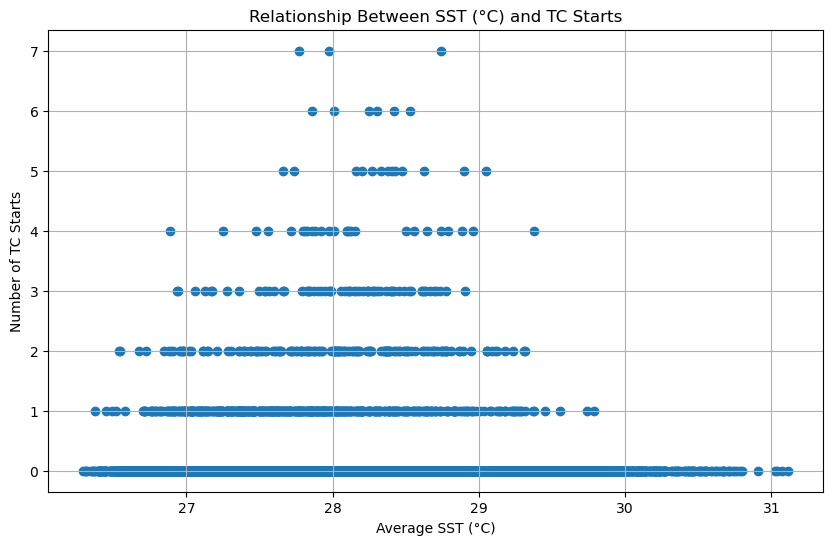

In [6]:
lat_edges = np.arange(-20, 21, 5)  # Adjust if necessary
lon_edges = np.arange(0, 360, 5)

result = {}  # Container for the results

for year in tropical_data['year'].values:
    sst_data = tropical_data.sel(year=year)['sst']
    tropical_mean_sst = sst_data.mean(dim=['latitude', 'longitude'], skipna=True).item()

    
    for lat_start, lat_end in zip(lat_edges[:-1],lat_edges[1:]):
        for lon_start, lon_end in zip(lon_edges[:-1],lon_edges[1:]):
            grid_box_data = sst_data.sel(latitude=slice(lat_end, lat_start), longitude=slice(lon_start, lon_end))
            
            if grid_box_data.size > 0:
                grid_box_mean_sst = grid_box_data.mean(dim=['latitude', 'longitude'], skipna=True).item()
               
                
                if grid_box_mean_sst > tropical_mean_sst:
                    tc_starts = 0
                    if year in storm_info:
                        for storm_data in storm_info[year].values():
                            storm_lat = storm_data['lat'][0]
                            storm_lon = storm_data['lon'][0]
                            if lat_start <= storm_lat <= lat_end and lon_start <= storm_lon+360 <= lon_end:
                                tc_starts += 1
                   
                    
                    if year not in result:
                        result[year] = []
                    result[year].append({
                        'gridbox': f'{lat_start}-{lat_end}, {lon_start}-{lon_end}',
                        'avg_sst': grid_box_mean_sst,
                        'TCs_started': tc_starts,
                        'year': year
                    })
            else:
                print(f"Grid box {lat_start}-{lat_end}, {lon_start}-{lon_end} is empty.")

ssts = []
counts = []
for y in result:
    for item in result[y]:
        ssts.append(item['avg_sst'] - 273.15)  # Convert Kelvin to Celsius
        counts.append(item['TCs_started'])

plt.figure(figsize=(10, 6))  
plt.scatter(ssts, counts)  
plt.title('Relationship Between SST (°C) and TC Starts') 
plt.xlabel('Average SST (°C)')  
plt.ylabel('Number of TC Starts')  
plt.grid(True)  
plt.show()

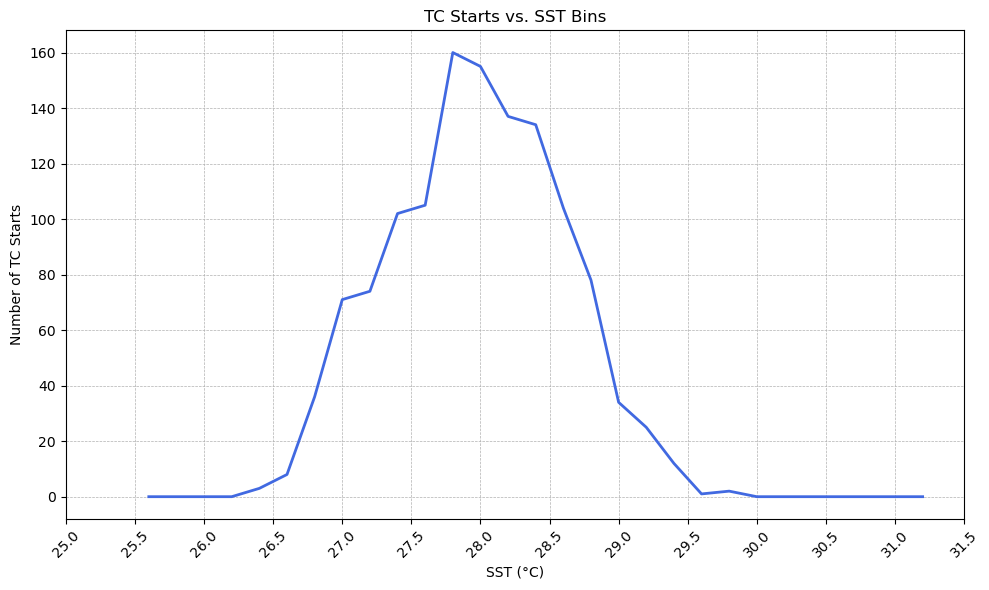

In [10]:
# Define SST bins from 26°C to 32°C with 0.5°C increments
sst_bins = np.arange(25.5, 31.5, 0.2) + 273.15
sst_midpoints = (sst_bins[:-1] + sst_bins[1:]) / 2 - 273.15  

# Initialize a list to hold the sum of TC starts for each SST bin
tc_starts_per_bin = np.zeros(len(sst_midpoints))

# Process each year's data
for year, items in result.items():
    for item in items:
        avg_sst = item['avg_sst']  # Already in Kelvin
        tc_starts = item['TCs_started']
        
        # Find the bin index for the current avg_sst
        bin_index = np.digitize(avg_sst, sst_bins) - 1  
        if 0 <= bin_index < len(tc_starts_per_bin):
            tc_starts_per_bin[bin_index] += tc_starts

# Now that tc_starts_per_bin and sst_midpoints have been defined, continue with the plotting:
sst_midpoints_array = np.array(sst_midpoints)
tc_starts_per_bin_array = np.array(tc_starts_per_bin)


custom_ticks = np.arange(25, 31.6, 0.5)
custom_labels = [f"{tick:.1f}" for tick in custom_ticks]
plt.figure(figsize=(10, 6))
plt.plot(sst_midpoints_array, tc_starts_per_bin_array, color='royalblue', linewidth=2, markersize=6)
plt.title('TC Starts vs. SST Bins')
plt.xlabel('SST (°C)')
plt.ylabel('Number of TC Starts')
plt.xticks(custom_ticks, custom_labels, rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
